In [1]:
import qiskit
from qiskit_aer import Aer
import numpy as np
from fractions import Fraction
from random import randint
import matplotlib.pyplot as plt

In [2]:
def euclidGCD(n, m):
    if(n%m == 0):
        return m
    else:
        return euclidGCD(m, n%m)

def qpe_amod15(a):
    # quantum algorithm for finding the smallest nonzero r such that a^r mod num = 1
    # we will use qiskit for this
    # note that this circuit only works for a = 7 and N = 15
    def c_amod15(a, power):
        """Controlled multiplication by a mod 15"""
        if a not in [2,4,7,8,11,13]:
            raise ValueError("'a' must be 2,4,7,8,11 or 13")
        U = qiskit.QuantumCircuit(4)
        for _iteration in range(power):
            if a in [2,13]:
                U.swap(2,3)
                U.swap(1,2)
                U.swap(0,1)
            if a in [7,8]:
                U.swap(0,1)
                U.swap(1,2)
                U.swap(2,3)
            if a in [4, 11]:
                U.swap(1,3)
                U.swap(0,2)
            if a in [7,11,13]:
                for q in range(4):
                    U.x(q)
        U = U.to_gate()
        U.name = f"{a}^{power} mod 15"
        c_U = U.control()
        return c_U
    def qft_dagger(n):
        """n-qubit QFTdagger the first n qubits in circ"""
        qc = qiskit.QuantumCircuit(n)
        # Don't forget the Swaps!
        for qubit in range(n//2):
            qc.swap(qubit, n-qubit-1)
        for j in range(n):
            for m in range(j):
                qc.cp(-np.pi/float(2**(j-m)), m, j)
            qc.h(j)
        qc.name = "QFT†"
        return qc
    N_COUNT = 8
    qc = qiskit.QuantumCircuit(4+N_COUNT, N_COUNT)
    for q in range(N_COUNT):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(N_COUNT) # And auxiliary register in state |1>
    for q in range(N_COUNT): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q),
                 [q] + [i+N_COUNT for i in range(4)])
    qc.append(qft_dagger(N_COUNT), range(N_COUNT)) # Do inverse-QFT
    qc.measure(range(N_COUNT), range(N_COUNT))
    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')
    # `memory=True` tells the backend to save each measurement in a list
    job = aer_sim.run(qiskit.transpile(qc, aer_sim), shots=1, memory=True)
    readings = job.result().get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**N_COUNT)
    print(f"Corresponding Phase: {phase}")
    return phase, qc

#assumimg num is not prime
def shors(num):
    #for even numbers
    if(num %2 == 0):
        return 2
    a = [2,4,7,8,11,13][2]
    # a = a+1
    gcd = euclidGCD(num,a)
    if(gcd != 1):
        return gcd
    
    FACTOR_FOUND = False
    ATTEMPT = 0
    while not FACTOR_FOUND:
        ATTEMPT += 1
        print(f"\nATTEMPT {ATTEMPT}:")
        phase,qc = qpe_amod15(a) # Phase = s/r
        frac = Fraction(phase).limit_denominator(num)
        r = frac.denominator
        print(f"Result: r = {r}")
        if phase != 0:
            # Guesses for factors are gcd(x^{r/2} ±1 , 15)
            guesses = [euclidGCD(a**(r//2)-1, num), euclidGCD(a**(r//2)+1, num)]
            print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
            for guess in guesses:
                if guess not in [1,num] and (num % guess) == 0:
                    # Guess is a factor!
                    print(f"*** Non-trivial factor found: {guess} ***")
                    FACTOR_FOUND = True
    return qc


ATTEMPT 1:
1
Register Reading: 00000000
Corresponding Phase: 0.0
Result: r = 1

ATTEMPT 2:
1
Register Reading: 11000000
Corresponding Phase: 0.75
Result: r = 4
Guessed Factors: 3 and 5
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***


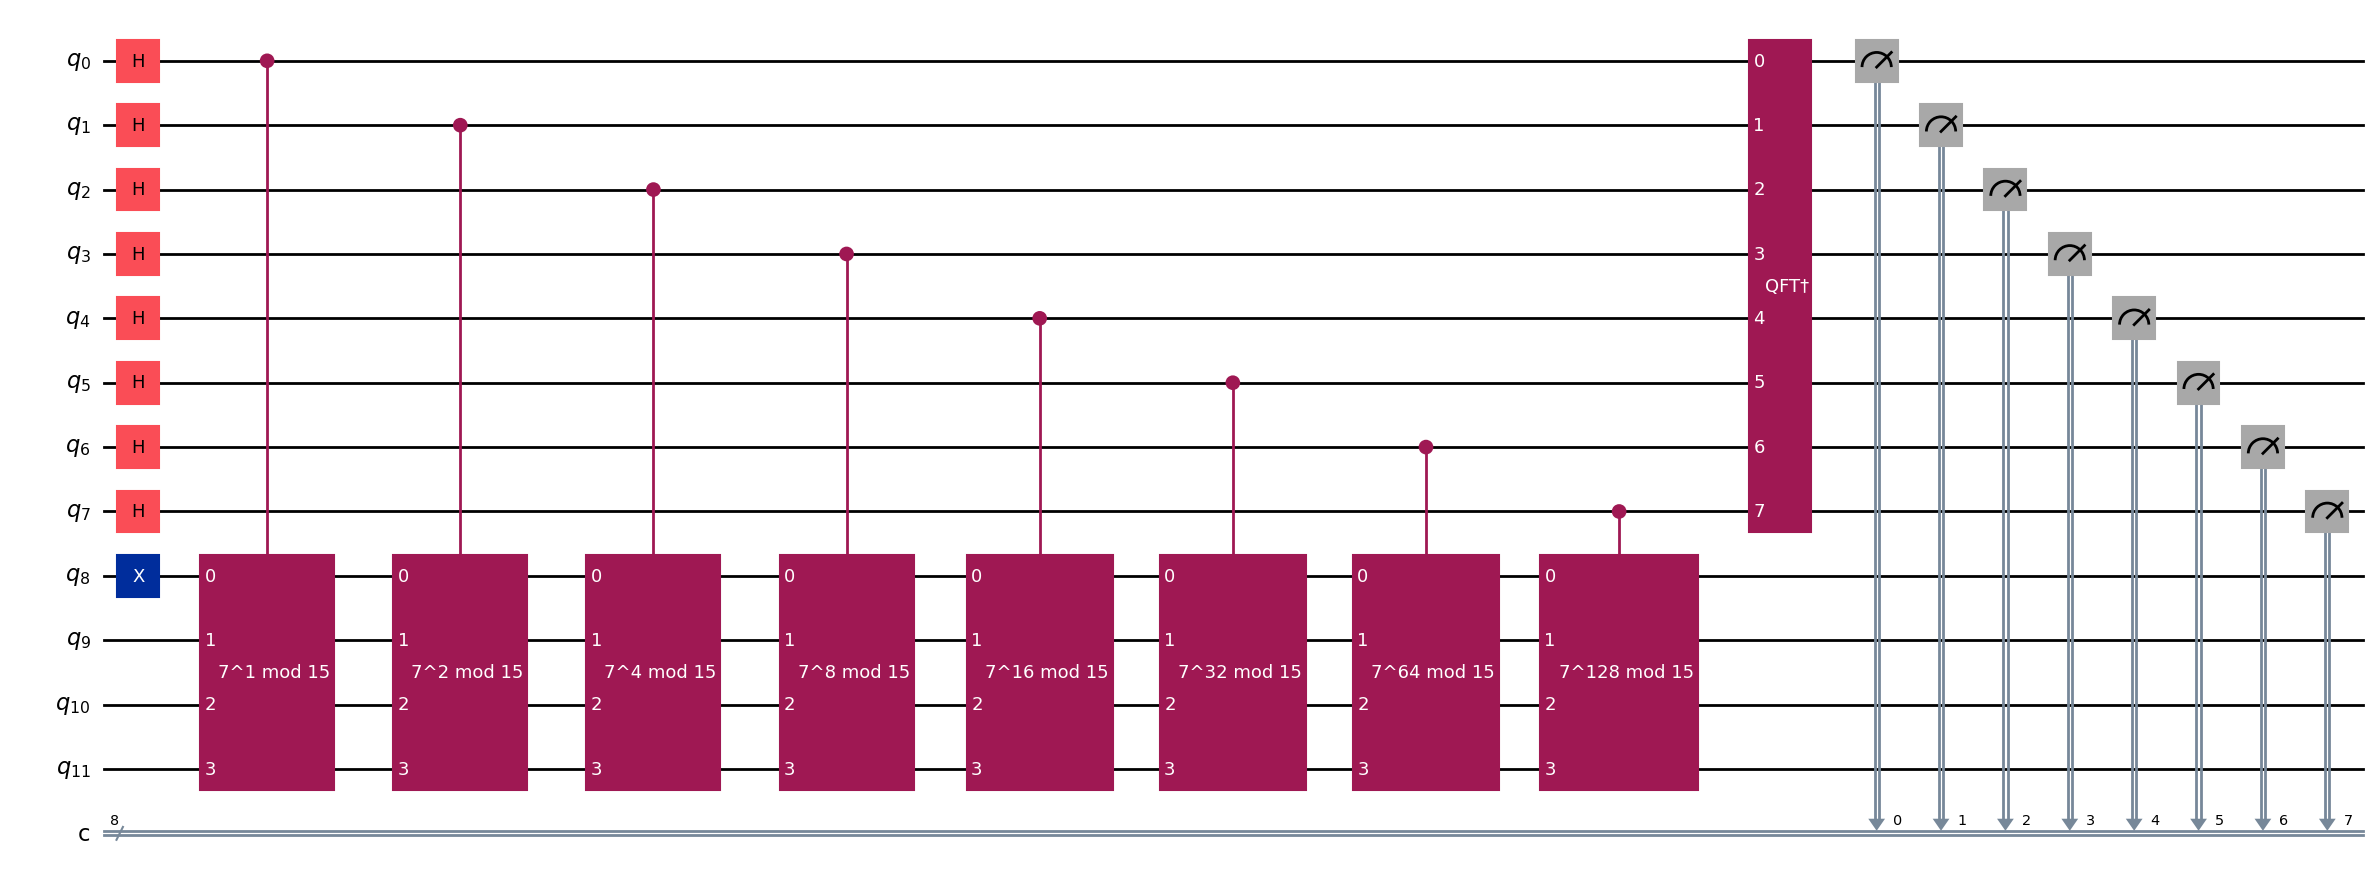

In [7]:
# test the function
qc = shors(15)
# print the circuit
qc.draw(output='mpl',filename='shors.png',fold=-1)